In [1]:
import copy
import importlib
import itertools
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as scist
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

from analysis import session, acr_sess_analys
from sess_util import sess_gen_util, sess_ntuple_util
from util import gen_util, logger_util, logreg_util, math_util, plot_util

importlib.reload(acr_sess_analys)

<module 'analysis.acr_sess_analys' from '/home/colleen/Documents/OpenScope_CA_Analysis/analysis/acr_sess_analys.py'>

In [2]:
plot_util.linclab_plt_defaults()

In [3]:
def init_sessions(sessid, datadir):
    sess = session.Session(datadir, sessid)
    print(f"Mouse {sess.mouse_n}, Session {sess.sess_n}")
    sess.extract_info()
    return sess

def extract_data_targ(sess, analyspar, stimpar):
    data, targ = [], []
    n_vals = []
    # reg, surp x ROIs x seq x frames
    data = acr_sess_analys.surp_data_by_sess(sess, analyspar, stimpar, datatype="roi", surp="bysurp", 
        integ=False, baseline=0.13)
    n_vals = [sub_data.shape[1] for sub_data in data]
    targ = np.concatenate([np.full(n, s) for s, n in enumerate(n_vals)])
    data = np.concatenate(data, axis=1)
    
    return data, targ, n_vals

In [4]:
def run_logreg(data, targ, n_splits, shuffle, scoring, seed):
    cv = logreg_util.StratifiedShuffleSplitMod(n_splits=n_splits, train_p=0.75, random_state=seed)
    scaler = logreg_util.ModData(scale=True, extrem=True, shuffle=shuffle, randst=seed)
    mod = LogisticRegression(C=1, fit_intercept=True, class_weight="balanced", penalty="l2", 
                             solver="lbfgs", max_iter=1000, random_state=seed, n_jobs=n_jobs)
    mod_pip = make_pipeline(scaler, mod)
    mod_cvs = cross_validate(mod_pip, data, targ, cv=cv, 
        return_estimator=True, return_train_score=True, n_jobs=8, 
        verbose=False, scoring=scoring)
    return mod_cvs

def plot_roi_acc(full_acc, roi_acc, full_diff, roi_diff, stimtype="gabors"):
    roi_acc_mean = np.mean(roi_acc, axis=-1)
    roi_acc_sem = scist.sem(roi_acc, axis=-1)
    full_acc_mean = np.mean(full_acc)
    full_acc_sem = scist.sem(full_acc)

    roi_diff_mean = np.mean(roi_diff, axis=-1)
    roi_diff_sem = scist.sem(roi_diff, axis=-1)
    full_diff_mean = np.mean(full_diff)
    full_diff_sem = scist.sem(full_diff)
    
    fig, ax = plt.subplots(1)
    ax.axhline(0.5, lw=2.5, color="gray", ls="dashed")
    ax.axvline(0.0, lw=2.5, color="gray", ls="dashed")
    ax.errorbar(roi_diff_mean, roi_acc_mean, yerr=roi_acc_sem, xerr=roi_diff_sem, 
                alpha=0.3, lw=0, marker=".", elinewidth=2.5)
    ax.errorbar(full_diff_mean, full_acc_mean, yerr=full_acc_sem, xerr=full_diff_sem, 
                lw=0, marker=".", elinewidth=2.5)
    ax.set_title(f"Surprise decoding accuracy per ROI ({stimtype.capitalize()})")
    ax.set_ylim([0, 1])

In [5]:
def get_diff_data(sess, analyspar, stimpar):
    data, targ, n_vals = extract_data_targ(sess, analyspar, stimpar)
    roi_diff = np.mean(data[:, n_vals[0] :], axis=1) - np.mean(data[:, : n_vals[0]], axis=1)
    full_diff = np.mean(roi_diff, axis=-1) # across frames
    return full_diff, roi_diff

def run_all_logreg(sessid, datadir, scoring, stimpar, n_splits, shuffle, seed):
    sess = init_sessions(sessid, datadir)
    analyspar_noscale = sess_ntuple_util.init_analyspar(scale=False)
    analyspar_scale = sess_ntuple_util.init_analyspar(scale=True)
    data, targ, n_vals = extract_data_targ(sess, analyspar_noscale, stimpar)
    print(f"Data shape: {', '.join([str(dim) for dim in data.shape])}")
    print(f"N vals: {', '.join([str(val) for val in n_vals])}")
    full_mod = run_logreg(np.transpose(data, [1, 2, 0]), targ, n_splits, shuffle, scoring, seed)
    full_acc = full_mod["test_balanced_accuracy"]
    roi_acc = np.full([len(data), n_splits], np.nan)
    for n, roi_data in enumerate(data):
        roi_mod = run_logreg(np.expand_dims(roi_data, -1), targ, n_splits, shuffle, scoring, seed)
        roi_acc[n] = roi_mod["test_balanced_accuracy"]
    full_diff, roi_diff = get_diff_data(sess, analyspar_scale, stimpar)
    return full_acc, roi_acc, full_diff, roi_diff

## PARAMETERS

In [6]:
pre = 0
gabfr = 0

In [7]:
n_reg = 10
n_shuff = 10
seed = 905
n_jobs = -1

datadir = Path("..", "data", "OSCA")
scoring = ["neg_log_loss", "accuracy", "balanced_accuracy"]

def set_all_parameters(stimtype):
    if stimtype == "gabors":
        post = 1.5
    elif stimtype == "bricks":
        post = 1.0

    stimpar = sess_ntuple_util.init_stimpar(stimtype, gabfr=gabfr, pre=pre, post=post)
    return stimpar

## Run regular

Mouse 1, Session 1
Loading stimulus and alignment info...
Creating stimulus objects...
Loading ROI trace info...
Data shape: 96, 1360, 45
N vals: 1266, 94


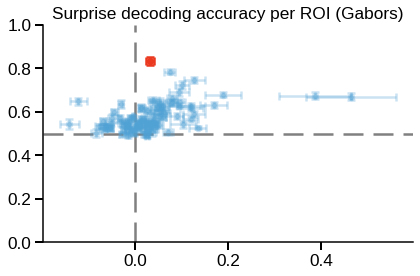

In [8]:
stimpar = set_all_parameters("gabors")
full_acc, roi_acc, full_diff, roi_diff = run_all_logreg(758519303, datadir, scoring, stimpar, n_splits=n_reg, shuffle=False, seed=seed)
plot_roi_acc(full_acc, roi_acc, full_diff, roi_diff, stimpar.stimtype)

Mouse 1, Session 2
Loading stimulus and alignment info...
Creating stimulus objects...
Loading ROI trace info...
Data shape: 74, 1360, 45
N vals: 1270, 90


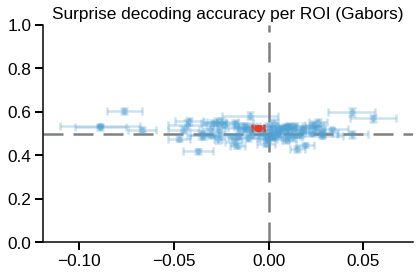

In [9]:
stimpar = set_all_parameters("gabors")
full_acc, roi_acc, full_diff, roi_diff = run_all_logreg(759189643, datadir, scoring, stimpar, n_splits=n_reg, shuffle=False, seed=seed)
plot_roi_acc(full_acc, roi_acc, full_diff, roi_diff, stimpar.stimtype)

Mouse 3, Session 1
Loading stimulus and alignment info...
Creating stimulus objects...
Loading ROI trace info...
Data shape: 87, 1360, 45
N vals: 1263, 97


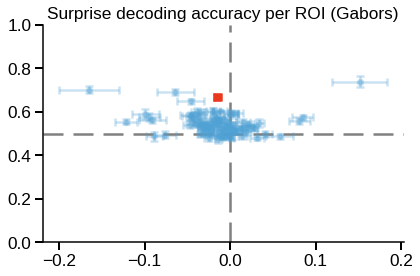

In [10]:
stimpar = set_all_parameters("gabors")
full_acc, roi_acc, full_diff, roi_diff = run_all_logreg(761624763, datadir, scoring, stimpar, n_splits=n_reg, shuffle=False, seed=seed)
plot_roi_acc(full_acc, roi_acc, full_diff, roi_diff, stimpar.stimtype)

Mouse 10, Session 3
Loading stimulus and alignment info...
Creating stimulus objects...
Loading ROI trace info...
Data shape: 496, 1360, 45
N vals: 1273, 87


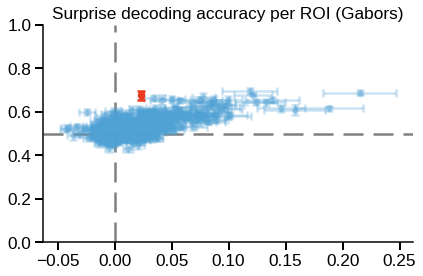

In [11]:
stimpar = set_all_parameters("gabors")
full_acc, roi_acc, full_diff, roi_diff = run_all_logreg(828816509, datadir, scoring, stimpar, n_splits=n_reg, shuffle=False, seed=seed)
plot_roi_acc(full_acc, roi_acc, full_diff, roi_diff, stimpar.stimtype)

Mouse 1, Session 1
Loading stimulus and alignment info...
Creating stimulus objects...
Loading ROI trace info...
Data shape: 96, 2040, 30
N vals: 1952, 88


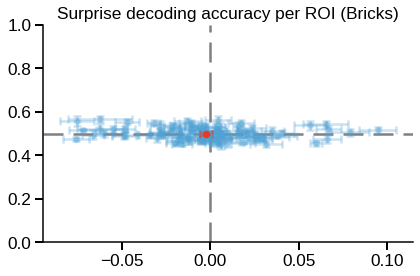

In [12]:
stimpar = set_all_parameters("bricks")
full_acc, roi_acc, full_diff, roi_diff = run_all_logreg(758519303, datadir, scoring, stimpar, n_splits=n_reg, shuffle=False, seed=seed)
plot_roi_acc(full_acc, roi_acc, full_diff, roi_diff, stimpar.stimtype)

Mouse 1, Session 2
Loading stimulus and alignment info...
Creating stimulus objects...
Loading ROI trace info...
Data shape: 74, 2040, 30
N vals: 1943, 97


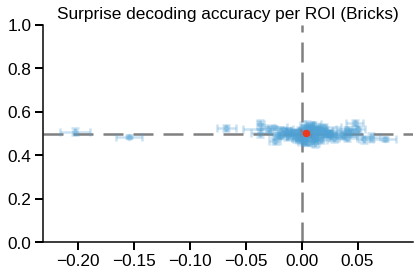

In [13]:
stimpar = set_all_parameters("bricks")
full_acc, roi_acc, full_diff, roi_diff = run_all_logreg(759189643, datadir, scoring, stimpar, n_splits=n_reg, shuffle=False, seed=seed)
plot_roi_acc(full_acc, roi_acc, full_diff, roi_diff, stimpar.stimtype)

Mouse 3, Session 1
Loading stimulus and alignment info...
Creating stimulus objects...
Loading ROI trace info...
Data shape: 87, 2040, 30
N vals: 1943, 97


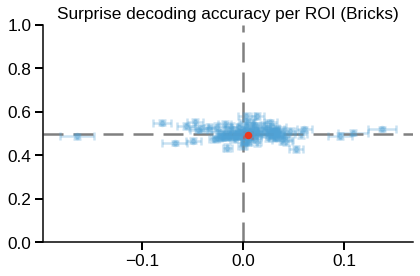

In [14]:
stimpar = set_all_parameters("bricks")
full_acc, roi_acc, full_diff, roi_diff = run_all_logreg(761624763, datadir, scoring, stimpar, n_splits=n_reg, shuffle=False, seed=seed)
plot_roi_acc(full_acc, roi_acc, full_diff, roi_diff, stimpar.stimtype)

Mouse 10, Session 3
Loading stimulus and alignment info...
Creating stimulus objects...
Loading ROI trace info...
Data shape: 496, 2040, 30
N vals: 1946, 94


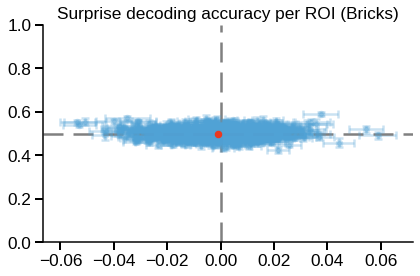

In [15]:
stimpar = set_all_parameters("bricks")
full_acc, roi_acc, full_diff, roi_diff = run_all_logreg(828816509, datadir, scoring, stimpar, n_splits=n_reg, shuffle=False, seed=seed)
plot_roi_acc(full_acc, roi_acc, full_diff, roi_diff, stimpar.stimtype)